In [2]:
import os
from Bio import Phylo
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ete3 import Tree
import json
import re

In [14]:
import sys
sys.path.append("$PATH/RamanomeSpec/scripts")
import Raman_tree
os.chdir("$PATH/ComparativeGenome")

## Compute marker gene trees by finding node in GTDB dataset

In [4]:
p = "../ComparativeGenome/GTDB_Database/gtdbtk.bac120.classify.tree" # GTDBTK tree profile based on all marker genes
p2 = "../ComparativeGenome/GTDB_Database/gtdb-search.csv" # the GTDB barcode ~ name, downloaded from GTDB dataset search results via Methylococcaceae

## New

In [84]:
imp.reload(Raman_tree)
# https://github.com/etetoolkit/ete/issues/194
tree = Raman_tree.read_tree(p,title="all",formatete3=1,quoted_node_names=True)
leafnames = tree.tree_g.get_leaf_names()
df = pd.read_csv("./genes.seqs.csv",index_col=0)
gtdb = pd.read_csv("./GTDB_Database/gtdb-search.csv")
with open("./dict_gc.json","r") as f:
    dict_gc = json.load(f)

In [120]:
# get the node name in db that matches the one I need to find
accessions = [] # save the node to be remained
accessions_dict = {} # save the node (accession number, strain name) pair
accessions_color_dict = {} # save the node (accession number,color) pair via dict_gc
notfound = []
i = 0
n, d = df.shape
for i in range(n):
    strain = df["strain_name"].iloc[i]
    name = df["gtdb_accession"].iloc[i]
# for strain,name in df[["strain_name","gtdb_accession"]]: # name I have
    tempi = i
    for namei in leafnames: # name in gtdb database
        
        # because of database differences, match only key part between _ and .
        if name != "bin_0":
            namepart = name[4:-2]
        else:
            namepart = name

        if namepart in namei:
            accessions.append(namei)
            if strain == "bin_0":
                accessions_dict[namei] = "Methylobacter multiphosphori" 
                accessions_color_dict[namei] = dict_gc[strain.split("_")[0]]
            else:
                accessions_dict[namei] = strain
                accessions_color_dict[namei] = dict_gc[strain.split(" ")[0]] # get the color via genus name
            i += 1 
            break
    if tempi == i :
        notfound.append(name)

print("not found: ", notfound)
print(len(accessions))
print(accessions)
with open("./accessions_color_dict.json","w") as f:
    json.dump(accessions_color_dict,f)

not found:  []
23
['RS_GCF_000496735.2', 'RS_GCF_002072955.1', 'RS_GCF_008632455.1', 'GB_GCA_002256705.1', 'RS_GCF_000934725.1', 'RS_GCF_000527095.1', 'RS_GCF_006175985.1', 'RS_GCF_000968535.2', 'RS_GCF_000384075.1', 'GCA_000785705.2', 'RS_GCF_000424685.1', 'GCA_000214275.3', 'bin_0', 'RS_GCF_003584645.1', 'RS_GCF_002923755.1', 'RS_GCF_001312005.1', 'RS_GCF_000733855.1', 'RS_GCF_000190755.2', 'RS_GCF_000733935.1', 'RS_GCF_000383855.1', 'RS_GCF_000372865.1', 'RS_GCF_001312345.1', 'RS_GCF_000963695.1']


In [129]:
# get the selected nodes and save
imp.reload(Raman_tree)

temptree = tree.tree_g.copy()
temptree.prune(accessions) # remain only selected leaf by prune
temptree.write(format=1, outfile="./Tree/Newick_FASTA/marker-gene-tree.newick")

# load the marker gene tree and plot
markertree = Raman_tree.read_tree("./Tree/Newick_FASTA/marker-gene-tree.newick",
                     special=accessions_dict,
                     title="marker gene tree")

with open("./accessions_color_dict.json","r") as f:
    accessions_color_dict = json.load(f)

markertree.set_color_range(accessions_color_dict,
                           nametype="accession")
markertree.tree_g.render("./Tree/Image/marker_tree.png",
                    tree_style=markertree.ts,w=3000,dpi=600)

"done"


1.0
0.165
1.0
1.0_f__Methylococcaceae
0.937
1.0
1.0_g__Methylovulum
0.686
0.729
0.912
1.0
1.0
0.531
1.0
1.0
0.98
0.788
0.999
1.0


'done'

# Viz the Evolution Blomberg K

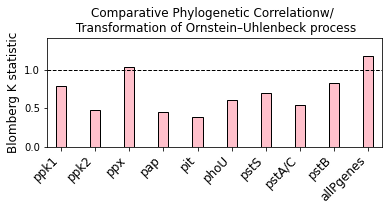

In [9]:
# after R markdown for the correlation statistics
def add_sig(ax,sig,x,y):
    """
    add siginificance to ax; 
    sig :: series object of siginificance p value
    x :: x values in figure
    y :: y values in figure 
    make sure ax and se in same order
    """
    for i,sigi in enumerate(sig):
        star = ''
        while sigi<=0.05:
            star += "*"
            sigi /= 10
            if sigi<0.05/1e4:
                break
        ax.text(x[i]-.2,y[i]*1.05,star)
    
# Plot here
def main(fileprefix="TRUEcorrelation"):
    pil = os.listdir("./comparative_genomics/")# path input list
    pil = [i for i in pil if fileprefix in i and 'png' not in i]
    pil = ['TRUEcorrelation0.4_final.csv']
    for p in pil:
        corr = pd.read_csv("./comparative_genomics/%s"%p,index_col=0)
        corr.index = ['P-value','Blomberg K Statistic']
        corr.columns = corr.columns.to_series().apply(lambda x: x.split(".")[0].replace("_","/")).values#.apply(), split(expand=True).
        d,n = corr.shape # 
        x = np.arange(n)
        y = corr.iloc[1,:]
        sig = corr.iloc[0,:]
        fig, ax = plt.subplots(1,1,figsize=(6,2))
        y.plot(x=x,kind='bar',ax=ax,ec='k',fc='pink',width=.3)
        ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45,ha='right',fontsize='large')
        ax.set_ylabel("Blomberg K statistic",fontsize='large')
        parameter = p.replace(fileprefix,"").replace(".csv","")
        ax.set_title("Comparative Phylogenetic Correlation"+\
                     "w/ \n Transformation of Ornstein–Uhlenbeck process")
#         ax.legend(labels=["$\mu$=%s"%parameter])
        add_sig(ax,sig,x,y)
        ax.set_ylim((0,y.max()*1.2))
        xlim = ax.get_xlim()
        labels = ax.get_xticklabels()
        ax.hlines(1,xlim[0],xlim[1],linestyles='dashed',linewidth=1)
        fig.savefig("./comparative_genomics/%s"%(p+".png"),bbox_inches='tight',dpi=600)
# main("correlation")
main("TRUEcorrelation")